In [1]:
# importing modules required

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import scipy as sc
import sklearn as sk
import statsmodels as st
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import warnings
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMAResults
from matplotlib import pyplot, legend, figure
from pandas import DataFrame
from scipy.stats import boxcox
from array import *

warnings.filterwarnings("ignore")

In [2]:
# read excel that is filtered to top 5 countries (ghg emissions)
df = pd.read_csv('canada_gdp.csv')

In [3]:
# get top 5 rows "df"
df.head()

Country  Year  GDP Value                                        Type of GDP
0  Canada  1990  21572.137  GDP per capita, current prices (U.S. dollars p...
1  Canada  1991  21885.570  GDP per capita, current prices (U.S. dollars p...
2  Canada  1992  20984.778  GDP per capita, current prices (U.S. dollars p...
3  Canada  1993  20210.452  GDP per capita, current prices (U.S. dollars p...
4  Canada  1994  20024.581  GDP per capita, current prices (U.S. dollars p...

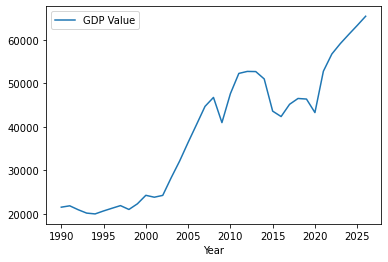

In [4]:
# plot time series of Year vs Gas Emitted - top5 countries (ghg)
top5_ghg_countries = df.groupby(['Year']).sum().plot()

In [5]:
# get top 5 rows of "top5_ghg_countries" after it have been summed, groupby year
top5_ghg_countries = df.groupby(['Year']).sum()
top5_ghg_countries.head()

GDP Value
Year           
1990  21572.137
1991  21885.570
1992  20984.778
1993  20210.452
1994  20024.581

In [6]:
reset_index = df.groupby(['Year']).sum().reset_index()

In [7]:
reset_index.columns

Index(['Year', 'GDP Value'], dtype='object')

In [8]:
year_2010 = reset_index.loc[reset_index['Year'] == 2010]

In [9]:
top5_ghg_countries['GDP Value']

Year
1990    21572.137
1991    21885.570
1992    20984.778
1993    20210.452
1994    20024.581
1995    20706.725
1996    21325.690
1997    21930.485
1998    21046.556
1999    22340.553
2000    24296.721
2001    23859.714
2002    24279.186
2003    28338.745
2004    32176.593
2005    36439.620
2006    40558.897
2007    44716.985
2008    46773.837
2009    40990.625
2010    47627.345
2011    52285.937
2012    52744.004
2013    52708.610
2014    51020.843
2015    43626.470
2016    42382.635
2017    45191.961
2018    46532.165
2019    46399.714
2020    43294.795
2021    52791.228
2022    56739.818
2023    59125.562
2024    61237.174
2025    63293.417
2026    65414.364
Name: GDP Value, dtype: float64

In [10]:
# top5_ghg_countries = top5_ghg_countries['Gas Emitted']

# naive prediction

# drop null values if there are

top5_ghg_countries.dropna(inplace=True)

# assigning training and testing dataset based on 50% split

top5_ghg_countries.dropna(inplace=True)

# assigning training and testing dataset based on 50% split
x = top5_ghg_countries.values

#x = x.astype('float32')
train_size = int(len(top5_ghg_countries) * 0.80)
train, test = x[0:train_size], x[train_size:]

In [11]:
# for every record from historical years, append into a list to be used for prediction

history = [x for x in train]
predictions = list()
year = 2003

for i in range(len(test)):
    # predictions
    yhat = history[-1]
    predictions.append(yhat)
    
    # observations
    obs = test[i]
    history.append(obs)
    year += 1
    print(str(year) +'>Predicted = %.3f, Expected = %3.f' % (yhat, obs))
    
# To calculate RMSE to see how well the model fits
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

2004>Predicted = 46532.165, Expected = 46400
2005>Predicted = 46399.714, Expected = 43295
2006>Predicted = 43294.795, Expected = 52791
2007>Predicted = 52791.228, Expected = 56740
2008>Predicted = 56739.818, Expected = 59126
2009>Predicted = 59125.562, Expected = 61237
2010>Predicted = 61237.174, Expected = 63293
2011>Predicted = 63293.417, Expected = 65414
RMSE: 4097.391


In [12]:
# plt.figure(figsize=(20,5))
# plt.grid()
# plt.plot(train['Gas Emitted'], label='Train')
# plt.plot(test['Gas Emitted'], label='Test')
# plt.plot(y_hat_naive['naive_forecast'], label='Naive forecast')
# plt.legend(loc='best')
# plt.title('Naive Method')
# plt.show()

In [13]:
#The RMSE is about 665.408. This means for each prediction, the model is 665.408 metric ton of CO2 equivalent emission wrong.

In [14]:
# ARIMA model 

# Dataset > period 1990 - 2003
# Validation set > period 2004 - 2018 
train_size = int(len(top5_ghg_countries) * 0.80)
split_point = len(top5_ghg_countries) - 15
dataset, validation = top5_ghg_countries[0:split_point], top5_ghg_countries[split_point:]

# number of years used in each set
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))

# save each set into a csv file
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

Dataset 22, Validation 15


In [15]:
# function arima

def evaluate_arima_model(X, arima_order):

    X = top5_ghg_countries.astype('float32')
    
    # assigning training and testing dataset based on 50% split
    train_size = int(len(X) * 0.80)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    # for every record from historical years, append into a list to be used for prediction
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        
        # expect trend to be non constant, hence trend = nc
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])

    # To calculate RMSE to see how well the model fits
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    return rmse

In [16]:
# search for optimal ARIMA parameters automatically

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s RMSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA = %s \nRMSE = %.3f' % (best_cfg, best_score))

In [17]:
p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(top5_ghg_countries.values, p_values, d_values, q_values)

Best ARIMA = None 
RMSE = inf


In [18]:
# Identify best ARIMA model manually

# check if stationary
result = adfuller(top5_ghg_countries)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    

ADF Statistic: 0.137256
p-value: 0.968515
Critical Values:
	1%: -3.627
	5%: -2.946
	10%: -2.612


In [19]:
# By looking at the p-value of this test, we cannot reject the null hypothesis, 
#and it is likely that our dataset is non-stationary. We therefore choose the first parameter in 
#our ARIMA model (the p) as a 1. We do not choose a higher number because although our 
#dataset is non-stationary, it is not likely that seasonality is present because we work with annual data.

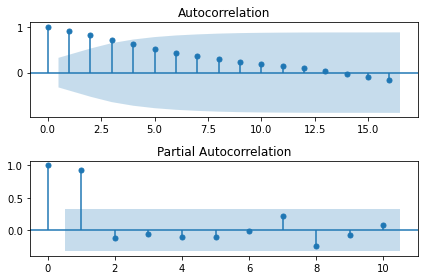

In [20]:
# Creates ACF and PACF plots
pyplot.figure()
pyplot.subplot(211)
plot_acf(top5_ghg_countries, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(top5_ghg_countries, ax=pyplot.gca(), lags = 10)
pyplot.tight_layout()
pyplot.show()

In [21]:
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    
    # prediction
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    
    #observation
    obs = test[i]
    history.append(obs)

# summarize residual errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())

                  0
count      8.000000
mean    1875.255232
std     3857.510186
min    -3065.093783
25%      940.464274
50%     1499.228184
75%     1714.750287
max    10434.439935


In [22]:
# saving the ARIMA model

def __getnewargs__(self):
	return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))
 
ARIMA.__getnewargs__ = __getnewargs__

model = ARIMA(x, order=(1,0,0))
model_fit = model.fit(trend='nc', disp=0)

bias = 1875.255232

model_fit.save('model.pkl')
np.save('model_bias.npy', [bias])

In [23]:
# load model and predict one period in the future

model_fit = ARIMAResults.load('model.pkl')
bias = np.load('model_bias.npy')
yhat = bias + float(model_fit.forecast()[0])
print('Predicted: %.3f' % yhat)

Predicted: 67132.938


In [24]:
# validate using dataset and validation set

# dataset
def difference(dataset):
        diff = list()
        for i in range(1, len(dataset)):
                value = dataset[i] - dataset[i - 1]
                diff.append(value)
        return diff

X = top5_ghg_countries.values
X = X.astype('float32')    

# difference data
stationary = difference(X)

df_X = pd.DataFrame({'Year': top5_ghg_countries.index.values, 'X':X.flatten()})

In [25]:
# validation set

validation = pd.read_csv('validation.csv')

def difference(validation):
        diff = list()
        for i in range(1, len(validation)):
                value = validation[i] - validation[i - 1]
                diff.append(value)
        return diff

y = np.array(validation['GDP Value'])
y = y.astype('float32')
      
stationary = difference(y)

df_y = pd.DataFrame({'Year': validation.index.values,'y':y.flatten()})


In [26]:
history = [x for x in X]

model_fit = ARIMAResults.load('model.pkl')
bias = np.load('model_bias.npy')

>Predicted = 67132.938, Expected = 52744
>Predicted = 54376.083, Expected = 52709
>Predicted = 54583.865, Expected = 51021
>Predicted = 52662.237, Expected = 43626
>Predicted = 45243.755, Expected = 42383
>Predicted = 44257.892, Expected = 45192
>Predicted = 46819.154, Expected = 46532
>Predicted = 48165.845, Expected = 46400
>Predicted = 48038.978, Expected = 43295
>Predicted = 45170.052, Expected = 52791
>Predicted = 54415.391, Expected = 56740
>Predicted = 58371.747, Expected = 59126
>Predicted = 60765.980, Expected = 61237
>Predicted = 62885.812, Expected = 63293
>Predicted = 64950.023, Expected = 65414
RMSE: 5187.08
MAE: 3419.35


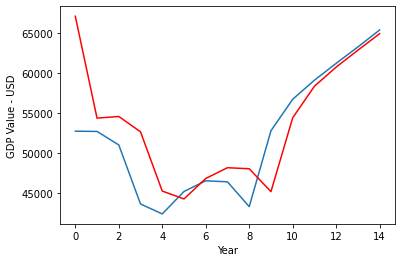

In [27]:
predictions = list()
yhat = bias + float(model_fit.forecast()[0])
predictions.append(yhat)
history.append(y[0])
print('>Predicted = %.3f, Expected = %3.f' % (yhat, y[0]))


for i in range(1, len(y)):
    model = ARIMA(history, order=(1,0,0))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = bias + float(model_fit.forecast()[0])
    predictions.append(yhat)

    obs=y[i]
    history.append(obs)
    year += 1
    print('>Predicted = %.3f, Expected = %3.f' % (yhat, obs))
    

mse = mean_squared_error(y, predictions)
rmse = sqrt(mse)
print('RMSE: %.2f' % rmse)
mae = mean_absolute_error(y, predictions)
print('MAE: %.2f' % mae)
# r2 = r2_score(y, predictions)
# print('R2: %.3f' % r2)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.xlabel('Year')
pyplot.ylabel('GDP Value - USD')
pyplot.show()

In [28]:
model_fit = ARIMAResults.load('model.pkl')
bias = np.load('model_bias.npy')
forecast = model_fit.forecast(steps=12)[0]
print (forecast)

[65257.68303884 65101.37736106 64945.44606778 64789.88826227
 64634.70304995 64479.88953838 64325.44683726 64171.37405842
 64017.67031583 63864.33472555 63711.36640581 63558.76447689]


Text(0, 0.5, 'GDP Value - USD')

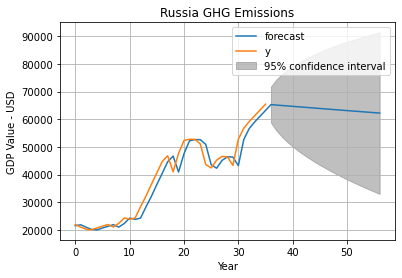

In [29]:
model_fit.plot_predict(1,57)
plt.grid()
plt.title('Russia GHG Emissions')
plt.xlabel('Year')
plt.ylabel('GDP Value - USD')

In [30]:
arr = (np.array([np.nan]))

In [31]:
arr

array([nan])

In [32]:
for i in range(36):
    predictions.insert(0,arr)

In [33]:
year_2030 = predictions[40][0]
round(year_2030,2)

45243.76

In [34]:
year_2010['GDP Value']

20    47627.345
Name: GDP Value, dtype: float64

Text(0, 0.5, 'GDP Value - Metric Ton')

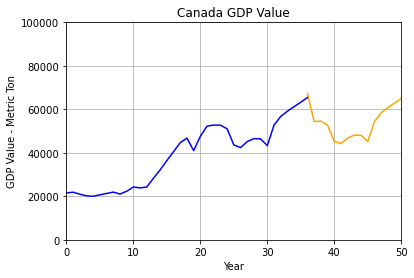

In [35]:
plt.grid()
plt.plot(predictions, color = 'orange' )
plt.plot(x, color = 'b')
plt.xlim ((0,50))
plt.ylim ((0,100000))
plt.title('Canada GDP Value')
plt.xlabel('Year')
plt.ylabel('GDP Value - Metric Ton')

In [36]:
for i in predictions:
    print(i[0])

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
67132.93827084209
54376.0834421409
54583.864576927605
52662.23736182849
45243.75529955653
44257.89188207731
46819.153658603514
48165.84503435865
48038.97783390226
45170.05206603482
54415.390570029915
58371.74729822593
60765.980398234096
62885.81231779977
64950.02279617203
